In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from kneed import KneeLocator

def remove_outliers(df_):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numerical_frame = df_.select_dtypes(include=numerics)
    for colname in numerical_frame.columns:
        Q1 = df_[colname].quantile(0.25)
        Q3 = df_[colname].quantile(0.75)
        IQR = Q3 - Q1
        df_ = df_[~((df_[colname]<(Q1-1.5*IQR))|(df_[colname]>(Q3+1.5*IQR)))]
    return df_

In [52]:
raw_data = pd.read_csv('Model_data.csv', index_col='TOTOID')
raw_data.rename(columns={'Lag':'DepositLag', 'AVGLag':'BetsLag'}, inplace=True)
raw_data.drop(columns=['UserID', 'RegDate'], inplace=True)

In [53]:
raw_data.head()

,Age,DepositCount,DepositAmount,DepositLag,BetsLag,Category,One_game,Second_game
TOTOID,,,,,,,,
101090251,38,38,67023.0,6.700000,1.297101,Live Casino,True,Slots
101131244,37,17,11700.0,15.666667,1.600000,Slots,True,Betongames
101185280,56,3,330.0,50.666667,1.682243,Slots,False,Betongames
101223495,32,321,82920.0,1.657658,1.404580,Slots,True,Live Casino
101069593,36,49,10965.0,5.545455,1.386364,Slots,True,Betongames


## MinMaxScaler

In [54]:
raw_data

,Age,DepositCount,DepositAmount,DepositLag,BetsLag,Category,One_game,Second_game
TOTOID,,,,,,,,
101090251,38,38,67023.0,6.700000,1.297101,Live Casino,True,Slots
101131244,37,17,11700.0,15.666667,1.600000,Slots,True,Betongames
101185280,56,3,330.0,50.666667,1.682243,Slots,False,Betongames
101223495,32,321,82920.0,1.657658,1.404580,Slots,True,Live Casino
101069593,36,49,10965.0,5.545455,1.386364,Slots,True,Betongames
...,...,...,...,...,...,...,...,...
101089769,41,6,4600.0,24.750000,2.000000,Slots,True,Betongames
101095966,34,19,19308.0,11.666667,2.000000,Slots,True,Betongames
101043287,46,4,1600.0,59.666667,1.777778,Slots,True,Betongames


In [55]:
raw_data = remove_outliers(raw_data)

In [56]:
raw_data['One_game'] = raw_data['One_game'].astype(int)
raw_data = pd.get_dummies(raw_data, prefix=['main', 'second'])

In [57]:
columns_to_scale = ['Age','DepositCount','DepositAmount','DepositLag','BetsLag']
minmax = raw_data.copy()
scaler = MinMaxScaler()
scaler.fit(minmax[columns_to_scale])
minmax[columns_to_scale] = scaler.transform(minmax[columns_to_scale])
minmax.drop_duplicates(keep='first', inplace=True)
minmax.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,Age,DepositCount,DepositAmount,DepositLag,BetsLag,One_game,main_Betongames,main_Live Casino,main_Other,main_P2P,...,main_TVGames,main_Virtual Games,second_Betongames,second_Live Casino,second_Other,second_P2P,second_Slots,second_Sports,second_TVGames,second_Virtual Games
count,62372.00000,62372.00000,62372.00000,62372.00000,62372.00000,62372.00000,62372.00000,62372.00000,62372.00000,62372.00000,...,62372.00000,62372.00000,62372.00000,62372.00000,62372.00000,62372.00000,62372.00000,62372.00000,62372.00000,62372.00000
mean,0.34964,0.17674,0.19998,0.21346,0.32276,0.94345,0.03755,0.00212,0.00022,0.00351,...,0.00027,0.00010,0.81628,0.02071,0.03154,0.04112,0.04391,0.02964,0.00112,0.00385
std,0.24861,0.20186,0.23535,0.22211,0.17417,0.23098,0.19010,0.04596,0.01498,0.05915,...,0.01651,0.00981,0.38726,0.14243,0.17476,0.19858,0.20491,0.16961,0.03348,0.06191
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,0.14894,0.03311,0.02784,0.05809,0.21298,1.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,0.29787,0.09934,0.09850,0.12164,0.25606,1.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
75%,0.48936,0.25166,0.29146,0.29043,0.36481,1.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
max,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000


In [58]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(minmax)
    sse.append(kmeans.inertia_)

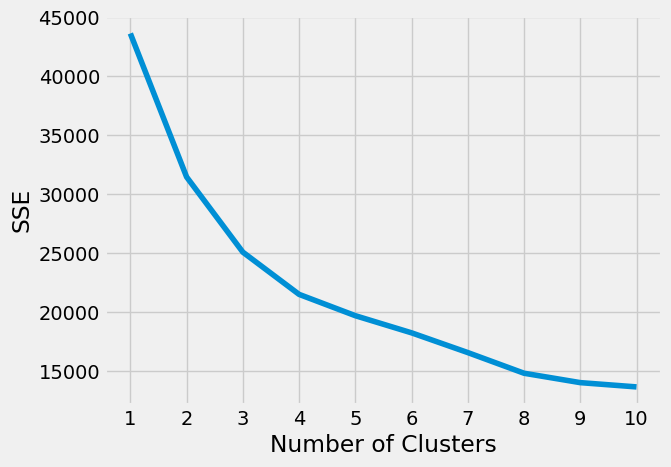

In [59]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [60]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
kl.elbow

4

In [61]:
raw_data

,Age,DepositCount,DepositAmount,DepositLag,BetsLag,One_game,main_Betongames,main_Live Casino,main_Other,main_P2P,...,main_TVGames,main_Virtual Games,second_Betongames,second_Live Casino,second_Other,second_P2P,second_Slots,second_Sports,second_TVGames,second_Virtual Games
TOTOID,,,,,,,,,,,,,,,,,,,,,
101090251,38,38,67023.0,6.700000,1.297101,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
101131244,37,17,11700.0,15.666667,1.600000,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
101185280,56,3,330.0,50.666667,1.682243,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
101069593,36,49,10965.0,5.545455,1.386364,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
101056840,27,6,1600.0,25.666667,1.374046,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101096307,30,10,1830.0,5.333333,4.363636,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
101089769,41,6,4600.0,24.750000,2.000000,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
101095966,34,19,19308.0,11.666667,2.000000,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


,Age,DepositCount,DepositAmount,DepositLag,BetsLag,One_game,main_Betongames,main_Live Casino,main_Other,main_P2P,...,main_TVGames,main_Virtual Games,second_Betongames,second_Live Casino,second_Other,second_P2P,second_Slots,second_Sports,second_TVGames,second_Virtual Games
TOTOID,,,,,,,,,,,,,,,,,,,,,
101090251,38,38,67023.0,6.700000,1.297101,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
101131244,37,17,11700.0,15.666667,1.600000,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
101185280,56,3,330.0,50.666667,1.682243,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
101069593,36,49,10965.0,5.545455,1.386364,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
101056840,27,6,1600.0,25.666667,1.374046,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101096307,30,10,1830.0,5.333333,4.363636,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
101089769,41,6,4600.0,24.750000,2.000000,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
101095966,34,19,19308.0,11.666667,2.000000,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [63]:
kmeans = KMeans(n_clusters=3, **kmeans_kwargs)
kmeans.fit(minmax)

KMeans(init='random', n_clusters=3, random_state=42)

In [64]:
kmeans_3_minmax = minmax.copy()
kmeans_3_minmax['label'] = kmeans.labels_

In [66]:
kmeans_3_minmax.to_excel('kmeans_3_minmax.xlsx')

In [67]:
minmax.head()

,Age,DepositCount,DepositAmount,DepositLag,BetsLag,One_game,main_Betongames,main_Live Casino,main_Other,main_P2P,...,main_TVGames,main_Virtual Games,second_Betongames,second_Live Casino,second_Other,second_P2P,second_Slots,second_Sports,second_TVGames,second_Virtual Games
TOTOID,,,,,,,,,,,,,,,,,,,,,
101090251,0.361702,0.245033,0.451517,0.066337,0.184095,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
101131244,0.340426,0.105960,0.078263,0.155116,0.263206,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
101185280,0.744681,0.013245,0.001552,0.501650,0.284686,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
101069593,0.319149,0.317881,0.073304,0.054905,0.207409,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
101056840,0.127660,0.033113,0.010120,0.254125,0.204192,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [68]:
kmeans = KMeans(n_clusters=4, **kmeans_kwargs)
kmeans.fit(minmax)

KMeans(init='random', n_clusters=4, random_state=42)

In [69]:
kmeans_4_minmax = minmax.copy()
kmeans_4_minmax['label'] = kmeans.labels_

In [70]:
kmeans_4_minmax.to_excel('kmeans_4_minmax.xlsx')

## Standard Scaler

In [74]:
standard = raw_data.copy()
scaler = StandardScaler()
scaler.fit(standard[columns_to_scale])
standard[columns_to_scale] = scaler.transform(standard[columns_to_scale])
standard.drop_duplicates(keep='first', inplace=True)
standard.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,Age,DepositCount,DepositAmount,DepositLag,BetsLag,One_game,main_Betongames,main_Live Casino,main_Other,main_P2P,...,main_TVGames,main_Virtual Games,second_Betongames,second_Live Casino,second_Other,second_P2P,second_Slots,second_Sports,second_TVGames,second_Virtual Games
count,62372.00000,62372.00000,62372.00000,62372.00000,62372.00000,62372.00000,62372.00000,62372.00000,62372.00000,62372.00000,...,62372.00000,62372.00000,62372.00000,62372.00000,62372.00000,62372.00000,62372.00000,62372.00000,62372.00000,62372.00000
mean,0.00000,0.00001,0.00001,-0.00005,0.00000,0.94345,0.03755,0.00212,0.00022,0.00351,...,0.00027,0.00010,0.81628,0.02071,0.03154,0.04112,0.04391,0.02964,0.00112,0.00385
std,1.00002,1.00001,1.00001,0.99994,1.00002,0.23098,0.19010,0.04596,0.01498,0.05915,...,0.01651,0.00981,0.38726,0.14243,0.17476,0.19858,0.20491,0.16961,0.03348,0.06191
min,-1.40640,-0.87552,-0.84971,-0.96102,-1.85315,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,-0.80732,-0.71148,-0.73141,-0.69952,-0.63033,1.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,-0.20824,-0.38341,-0.43117,-0.41340,-0.38296,1.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
75%,0.56201,0.37116,0.38870,0.34648,0.24139,1.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
max,2.61599,4.07838,3.39924,3.54096,3.88837,1.00000,1.00000,1.00000,1.00000,1.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000


In [75]:
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(standard)
    sse.append(kmeans.inertia_)

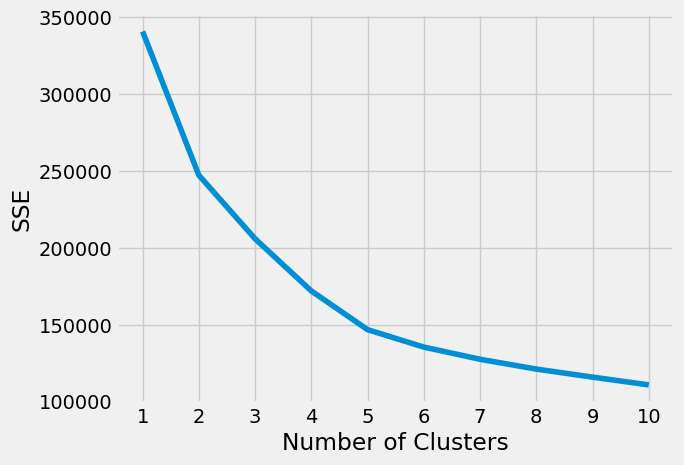

In [76]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [77]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
kl.elbow

4

In [79]:
kmeans = KMeans(n_clusters=3, **kmeans_kwargs)
kmeans.fit(standard)

KMeans(init='random', n_clusters=3, random_state=42)

In [80]:
kmeans_3_standard = standard.copy()
kmeans_3_standard['label'] = kmeans.labels_

In [81]:
kmeans_3_standard.to_excel('kmeans_3_standard.xlsx')

In [83]:
kmeans = KMeans(n_clusters=4, **kmeans_kwargs)
kmeans.fit(standard)

KMeans(init='random', n_clusters=4, random_state=42)

In [84]:
kmeans_4_standard = standard.copy()
kmeans_4_standard['label'] = kmeans.labels_

In [85]:
kmeans_4_standard.to_excel('kmeans_4_standard.xlsx')

## Standard All